In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

- INSTALL ADDITIONAL LIBRARIES IF REQUIRED
------------------------------------------
This is normally not required. The hub environment comes preinstaled with 
many packages that you can already use without setup. In case there is some
other library you would like to use that isn't on the list you run this command
once to install them.  If it is already installed this command has no effect.

In [2]:
get_ipython().system('python3 -m pip install db-dtypes pmdarima')

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


- IMPORT THE LIBRARIES YOU WILL USE
------------------------------------------
You only need to import packages one time per notebook session. To keep your
notebook clean and organized you can handle all imports at the top of your file.
The following are included for example purposed, feel free to modify or delete 
anything in this section.

In [3]:
import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.model_selection import train_test_split 
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from pmdarima.arima import auto_arima

CONFIGURE THE BIGQUERY SETTINGS

In [4]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [5]:
query = """
Select a.*, b.average_wage FROM 
(SELECT * FROM `ironhacks-data.ironhacks_competition.unemployment_data`) a
JOIN `ironhacks-data.ironhacks_competition.wage_data` b 
ON a.uu_id=b.uu_id
order by uu_id, week_number
"""

In [6]:
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
empdata = query_job.to_dataframe().drop_duplicates().fillna(0)

In [7]:
empdata.head().transpose()

,0,1,3,5,7
uu_id,001cd9ae23064d7f0fd3cd327c873d8d,001cd9ae23064d7f0fd3cd327c873d8d,001cd9ae23064d7f0fd3cd327c873d8d,001cd9ae23064d7f0fd3cd327c873d8d,001cd9ae23064d7f0fd3cd327c873d8d
timeperiod,20220730,20220813,20220820,20220827,20220903
week_number,31,33,34,35,36
countyfips,18099,18099,18099,18099,18099
tract,20102,20102,20102,20102,20102
tract_name,"Census Tract 201.02, Marshall County, Indiana","Census Tract 201.02, Marshall County, Indiana","Census Tract 201.02, Marshall County, Indiana","Census Tract 201.02, Marshall County, Indiana","Census Tract 201.02, Marshall County, Indiana"
total_claims,34,10,25,10,10
edu_8th_or_less,0,0,0,0,0
edu_grades_9_11,0,0,0,0,0
edu_hs_grad_equiv,30,0,0,0,0


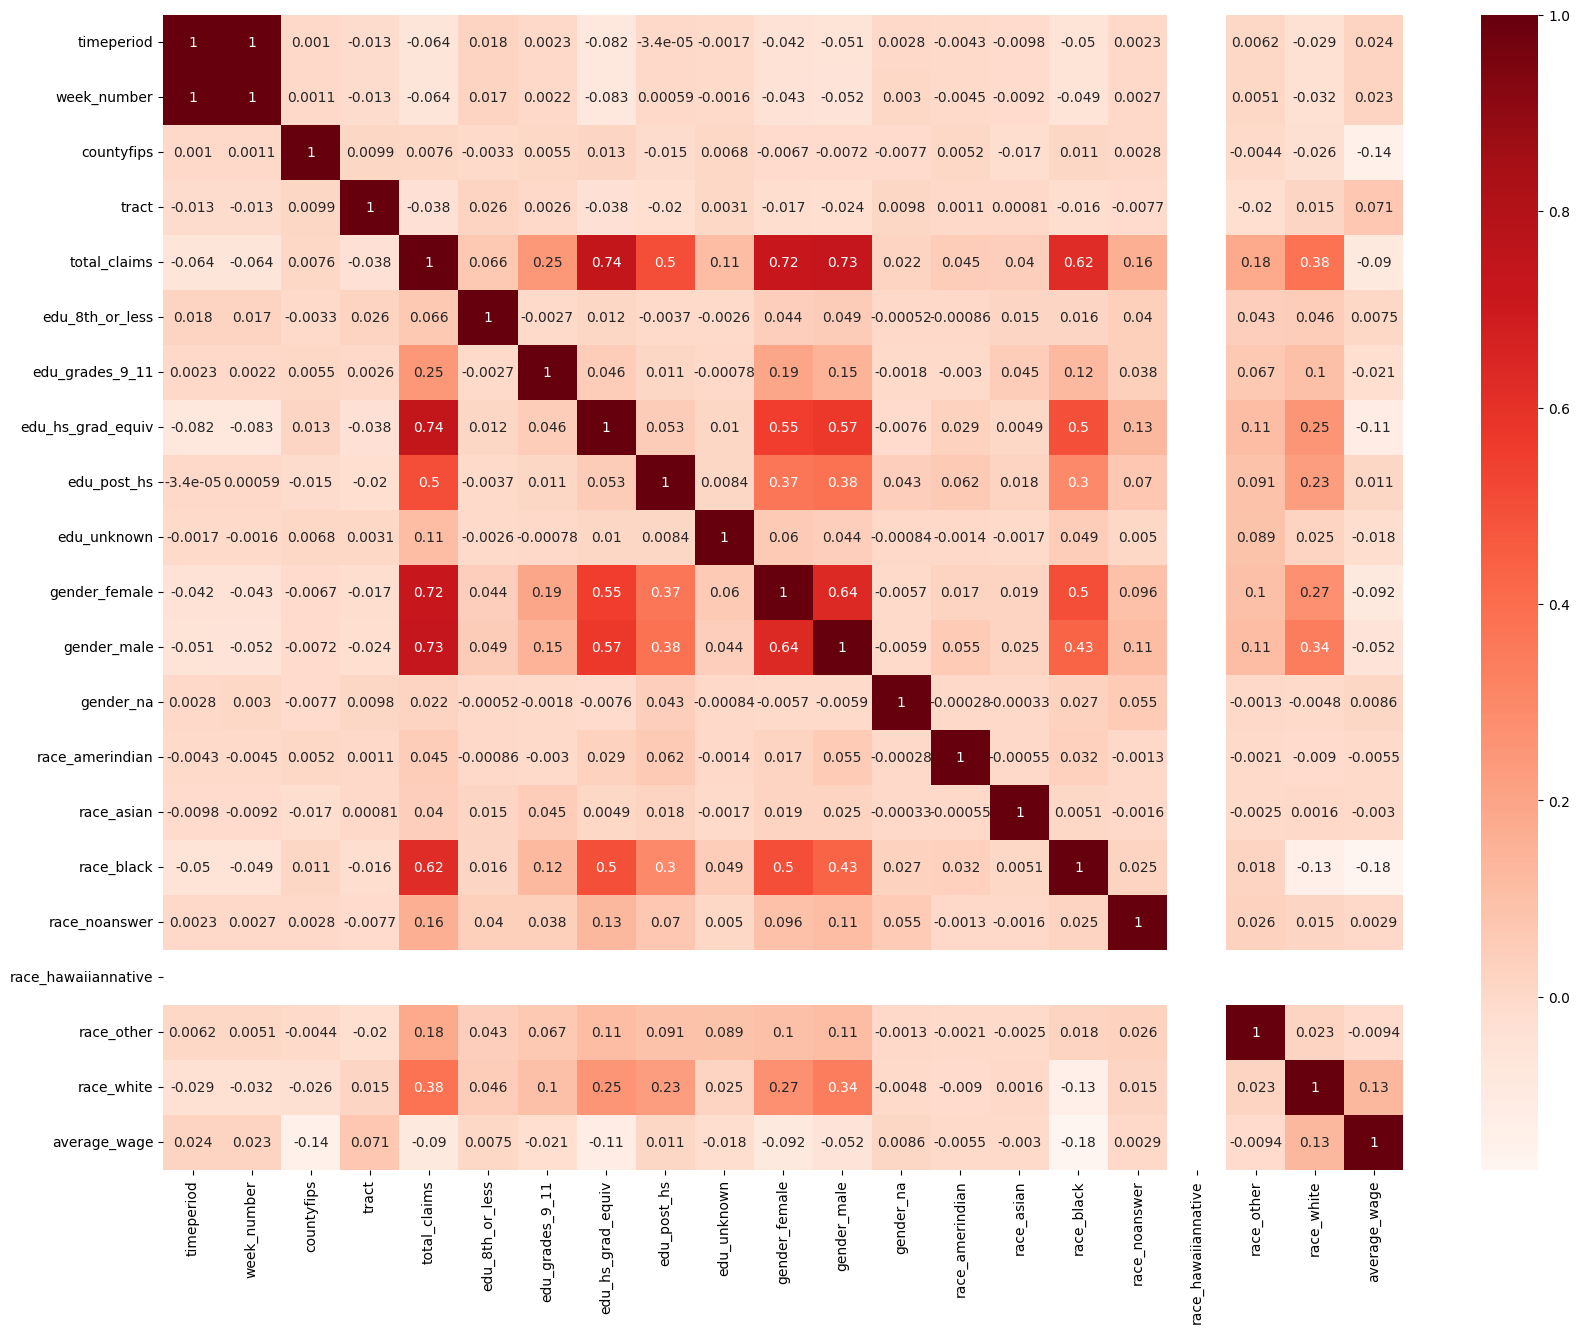

In [8]:
plt.figure(figsize=(20,15))
cor = empdata.corr(numeric_only=True)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [9]:
empdata = empdata[['uu_id', 'week_number', 'total_claims']]
empdata.head(10)

,uu_id,week_number,total_claims
0,001cd9ae23064d7f0fd3cd327c873d8d,31,34
1,001cd9ae23064d7f0fd3cd327c873d8d,33,10
3,001cd9ae23064d7f0fd3cd327c873d8d,34,25
5,001cd9ae23064d7f0fd3cd327c873d8d,35,10
7,001cd9ae23064d7f0fd3cd327c873d8d,36,10
9,001cd9ae23064d7f0fd3cd327c873d8d,37,13
11,005be9532fd717dc36d4be318fd9ad25,1,20
12,005be9532fd717dc36d4be318fd9ad25,2,19
13,005be9532fd717dc36d4be318fd9ad25,3,19
14,005be9532fd717dc36d4be318fd9ad25,5,15


<AxesSubplot: xlabel='week_number'>

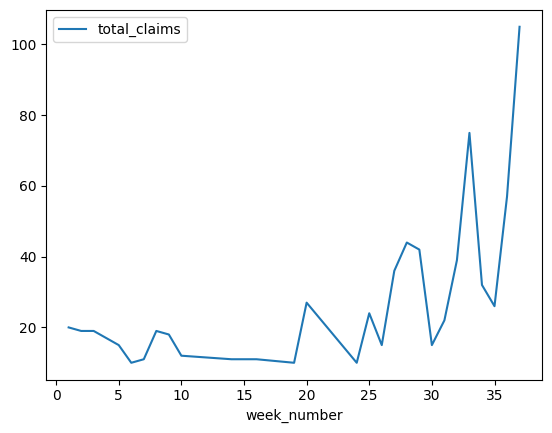

In [10]:
empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"].plot(x='week_number', y='total_claims')

In [11]:
empdata[['total_claims']].describe()

,total_claims
count,13977.0
mean,23.049796
std,14.68286
min,10.0
25%,14.0
50%,19.0
75%,27.0
max,170.0


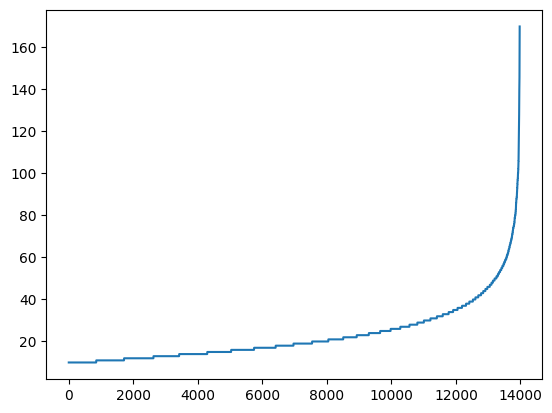

In [12]:
plt.plot(np.sort(empdata['total_claims'].values))

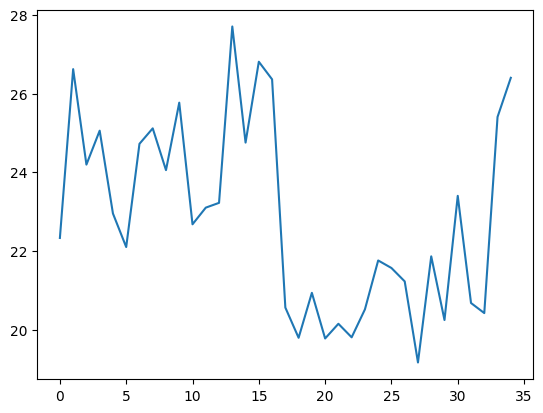

In [13]:
meancpw = []
for i in np.sort(empdata['week_number'].unique()):
    meancpw.append(empdata.loc[empdata['week_number'] == i][['total_claims']].mean())
plt.plot(meancpw)

total_claims    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

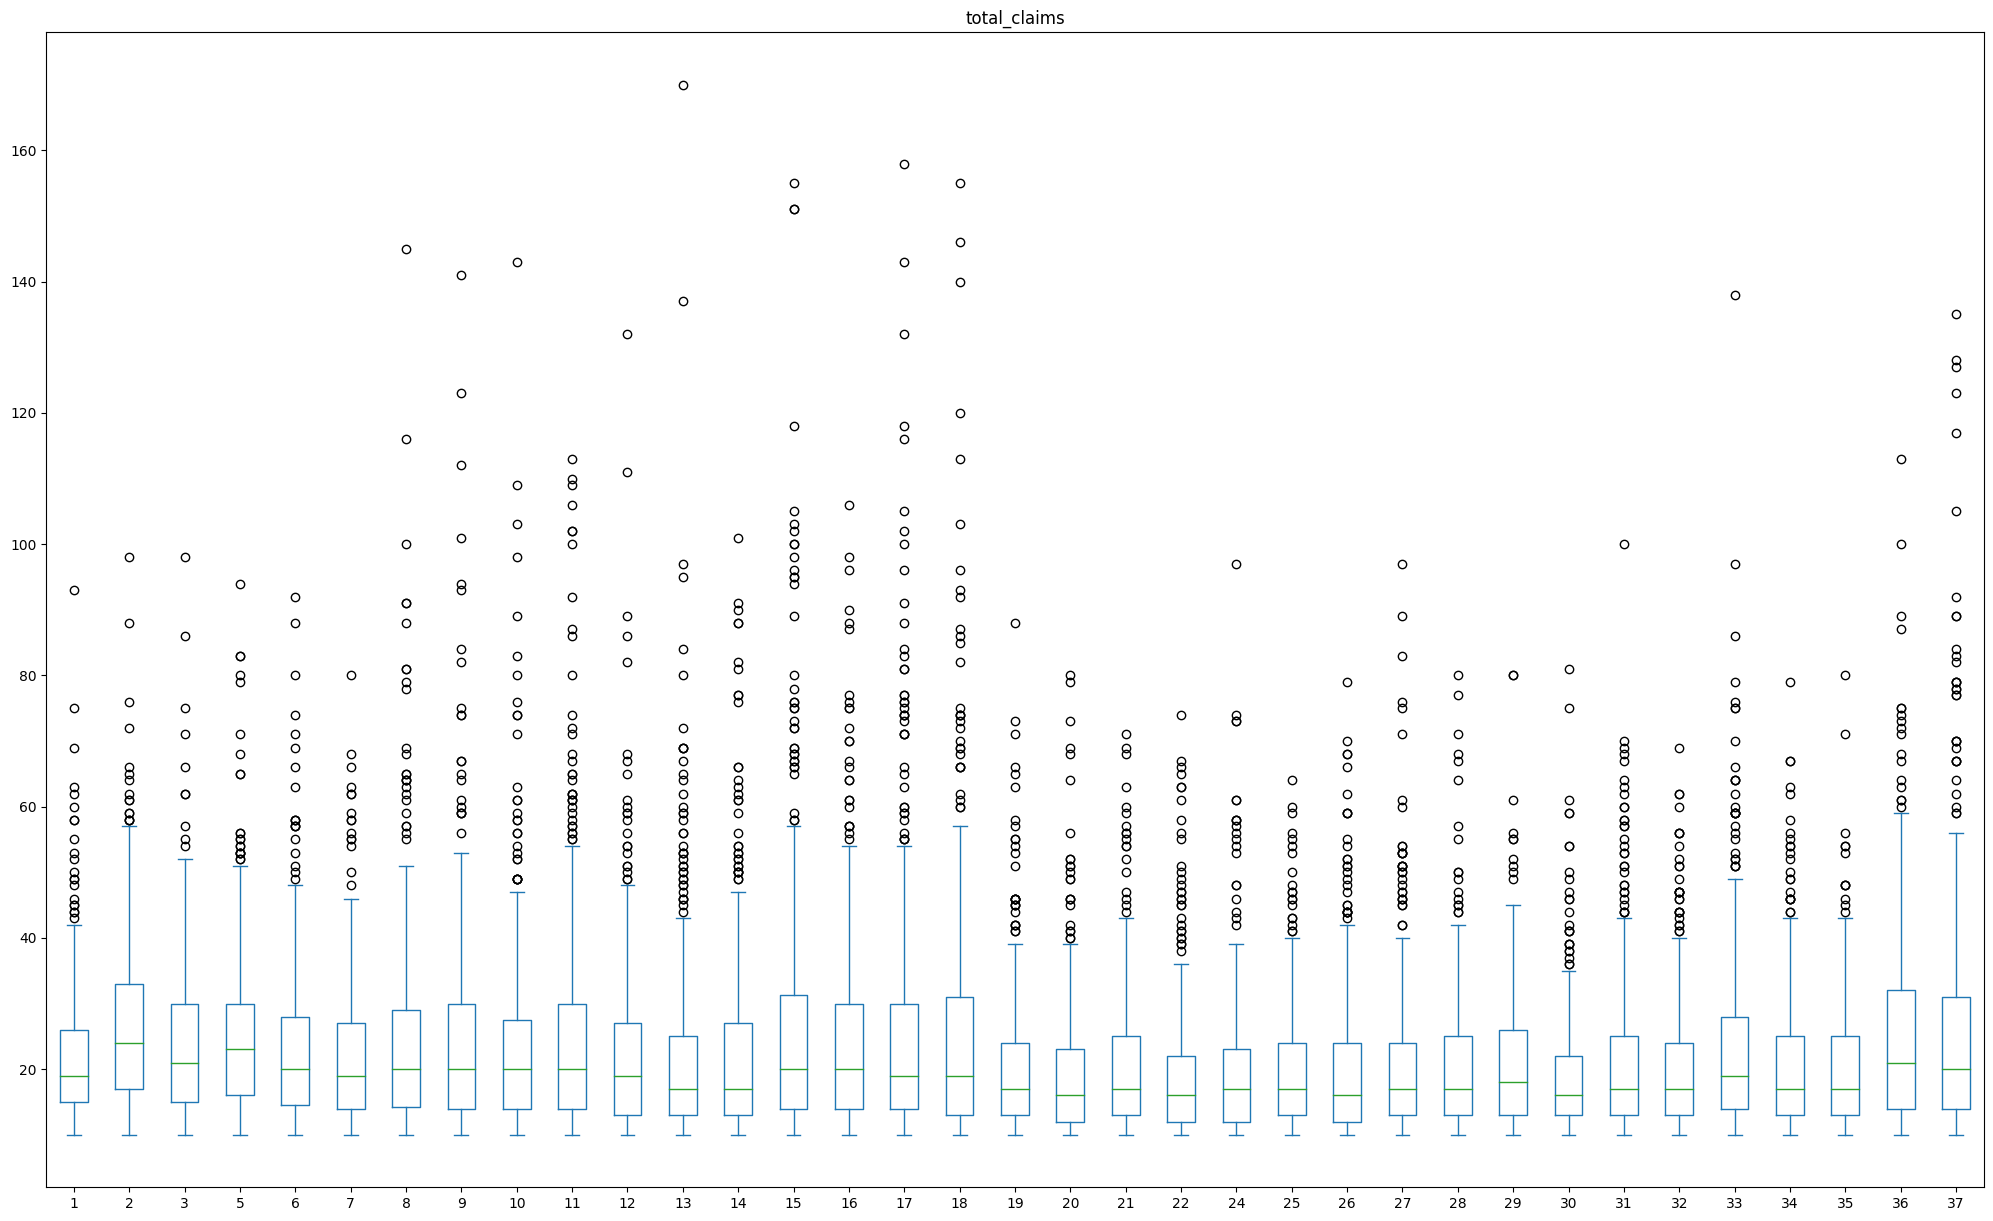

In [14]:
empdata.plot.box('week_number', figsize=(25,15))

In [15]:
empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"]

,uu_id,week_number,total_claims
11,005be9532fd717dc36d4be318fd9ad25,1,20
12,005be9532fd717dc36d4be318fd9ad25,2,19
13,005be9532fd717dc36d4be318fd9ad25,3,19
14,005be9532fd717dc36d4be318fd9ad25,5,15
15,005be9532fd717dc36d4be318fd9ad25,6,10
16,005be9532fd717dc36d4be318fd9ad25,7,11
17,005be9532fd717dc36d4be318fd9ad25,8,19
18,005be9532fd717dc36d4be318fd9ad25,9,18
19,005be9532fd717dc36d4be318fd9ad25,10,12
20,005be9532fd717dc36d4be318fd9ad25,14,11


In [16]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,37+1)}).join(testuu_id, on='week_number')
allweeks

,week_number,total_claims
0,1,20
1,2,19
2,3,19
3,4,<NA>
4,5,15
5,6,10
6,7,11
7,8,19
8,9,18
9,10,12


In [17]:
m = pm.auto_arima(allweeks['total_claims'].values, error_action='ignore')
m.predict(n_periods=6)[5]

ValueError: cannot convert to 'float64'-dtype NumPy array with missing values. Specify an appropriate 'na_value' for this dtype.